In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.signal import argrelextrema
from tqdm.notebook import tqdm
import mplfinance as mpf

import sys

sys.path.insert(0,'/Users/orentapiero/btc_research/')

from btc_functions.glassnode import *
from btc_functions.import_data import get_glassnode_price,get_glassnode_data
from btc_functions.variable_list_urls import *
from btc_functions.utilities import strided_app,strided_app2

plt.rcParams['figure.figsize'] = [18, 10]
sns.set()

In [2]:
def bar_create(ohlc,what = 'transfers_volume_sum',th=5):
    df = ohlc.copy()
    group = pd.Series(index = df.index, dtype = float, name = 'group')
    N = len(group)

    t = ohlc[what] #100*np.log(ohlc['Close']/ohlc['Open'])
    ts = 0
    idx = []

    for i, x in enumerate(t):
        ts += x
        if np.abs(ts) > th:
            idx.append(i)
            ts = 0.0
            continue

    group.iloc[idx]  = idx
    group.fillna(method = 'bfill',inplace = True)
    group.fillna(method = 'ffill',inplace = True)

    df.loc[:,'group'] = group
    df.loc[:,'Time'] = df.index

    fTime = df.groupby('group')['Time'].first()
    lTime = df.groupby('group')['Time'].last()
    Time_ = pd.concat([fTime,lTime],axis = 1)
    Time_.columns = ['open','close']
    Time_.index = Time_.close
    Time_.loc[:,'dt'] = (Time_.close-Time_.open).dt.total_seconds()


    Open = df.groupby('group')['Open'].first()
    High = df.groupby('group')['High'].max()
    Low = df.groupby('group')['Low'].min()
    Close = df.groupby('group')['Close'].last()

    newOhlc = pd.concat([Open,High,Low,Close],axis = 1)
    newOhlc.index = lTime
    return newOhlc,group

def check_direction(R):
    pos = (R>0) & (R.shift(1)>0)
    neg = (R<=0) & (R.shift(1)<=0)

    mask = pos | neg
    return mask.sum()/mask.count()

In [3]:
Urls['transfers_volume_sum'] = 'https://api.glassnode.com/v1/metrics/transactions/transfers_volume_sum'
Urls['ssr'] = 'https://api.glassnode.com/v1/metrics/indicators/ssr'

In [4]:
ohlc = get_glassnode_price()
ohlc = ohlc.rename(columns = {'o':'Open','h':'High','l':'Low','c':'Close'})
ohlc = ohlc#.loc[:'2019']

# selected = ['marketcap_usd',
#             'mvrv_z_score',
#             'sopr',
#             'sopr_adjusted',
#             'puell_multiple',
#             'net_unrealized_profit_loss',
#             'ssr',
#             'transfers_volume_sum',
#             'transfers_volume_exchanges_net',
#             'dormancy_flow',
#             'reserve_risk']

selected = ['marketcap_usd',
            'mvrv_z_score',
            'sopr_adjusted',
            'puell_multiple',
            'net_unrealized_profit_loss',
            'transfers_volume_sum',
            'transfers_volume_exchanges_net',
            'dormancy_flow',
            'reserve_risk',
            'cdd90_age_adjusted',
            'average_dormancy',
            'liveliness', 
            'realized_profits_to_value_ratio',
            'rhodl_ratio',
            'cvdd',
            'nvts', 
            'marketcap_thermocap_ratio',
            'difficulty_latest', 
            'non_zero_count']

features = get_glassnode_data(selected,Urls)
features = features#.loc[:'2019']

  0%|          | 0/19 [00:00<?, ?it/s]

# Puell multiple

- Cycle top > 4
- Local Top < 4 and >3
- Cycle bottom < 0.5

In [5]:
def local_min_max(df,col,L):
    df[col+'_ma_'+str(L)] = df[col].rolling(L).mean()
    x = df[col+'_ma_'+str(L)].copy()
    
    Lmin = x.loc[(x.shift(1)>x) & (x.shift(-1)>x)].rename(col+'_min')
    Lmax = x.loc[(x.shift(1)<x) & (x.shift(-1)<x)].rename(col+'_max')
    
    df_ = pd.concat([df,Lmin,Lmax],axis = 1)
    
    return df_

In [6]:
df = pd.concat([ohlc.Close,features['puell_multiple']],axis = 1).dropna()
df = local_min_max(df,'puell_multiple',20).copy()
df['log_puell_ma'] = np.log(df['puell_multiple_ma_20'])

<AxesSubplot:xlabel='t'>

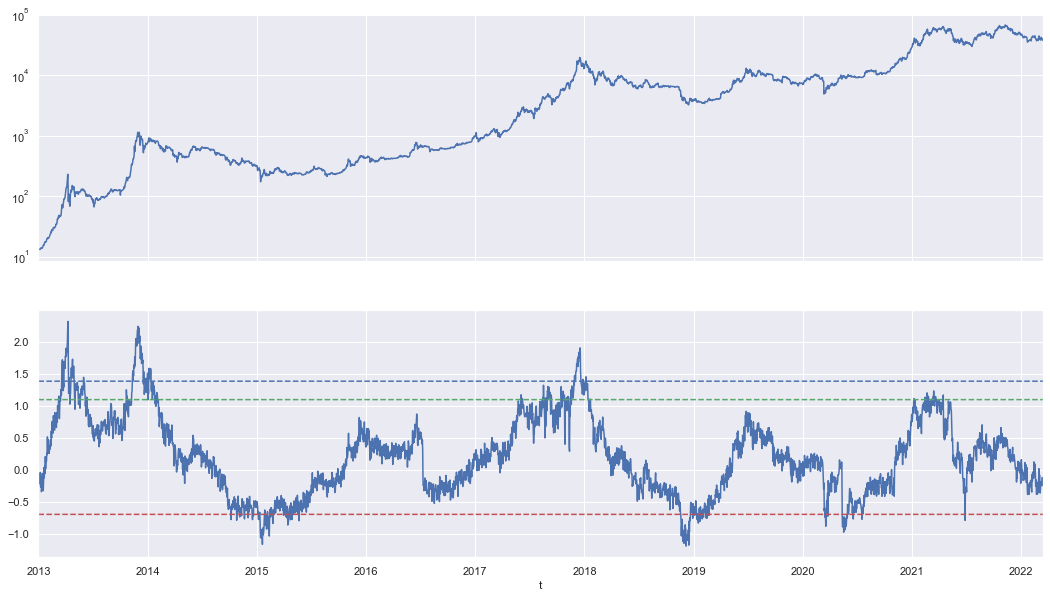

In [7]:
cycle_top = pd.Series(4,index = df.index)
local_top = pd.Series(3,index = df.index)
cycle_bottom = pd.Series(0.5,index = df.index)

f,a = plt.subplots(nrows = 2, sharex = True)
df['Close'].plot(ax = a[0],logy = True)

np.log(df['puell_multiple']).plot(ax = a[1])
np.log(cycle_top).plot(ax = a[1],style = 'b--')
np.log(local_top).plot(ax = a[1],style = 'g--')
np.log(cycle_bottom).plot(ax = a[1],style = 'r--')


In [8]:
df['R']=100*(df.Close/df.Close.shift(1)-1)
# df = df.dropna().copy()

df['q_puell'] = pd.qcut(df['log_puell_ma'].diff(20).shift(1),3)

avg = df.groupby('q_puell')['R'].apply(lambda x: x.mean()/x.std()).rename('std_avg')
prc = df.groupby('q_puell')['R'].apply(lambda x: x[x>0].count()/x.count()).rename('prc')
cnt = df.groupby('q_puell')['R'].count().rename('N')

pd.concat([avg,prc,cnt],axis=1)


,std_avg,prc,N
q_puell,,,
"(-0.776, -0.0725]",0.021095,0.498645,1107
"(-0.0725, 0.0716]",0.031320,0.536166,1106
"(0.0716, 0.823]",0.143124,0.581752,1107


In [9]:
print('above 4:',
      df.loc[df.puell_multiple.shift(1)>4,'R'].mean())
print('between 3 and 4:',
      df.loc[(df.puell_multiple.shift(1)<4) & (df.puell_multiple.shift(1)>3) ,'R'].mean())
print('between 0.5 and 3:',
      df.loc[(df.puell_multiple.shift(1)<3) & (df.puell_multiple.shift(1)>0.5) ,'R'].mean())
print('below 0.5:',
      df.loc[(df.puell_multiple.shift(1)<0.5),'R'].mean())

above 4: 1.2870098243094774
between 3 and 4: 0.5878347573743103
between 0.5 and 3: 0.29519439349920773
below 0.5: 0.25322945429577615


In [10]:
print('above 4:',
      df.loc[df.puell_multiple.shift(1)>4,'R'].mean()/df.loc[df.puell_multiple.shift(1)>4,'R'].std())
print('between 3 and 4:',
      df.loc[(df.puell_multiple.shift(1)<4) & (df.puell_multiple.shift(1)>3) ,'R'].mean()/df.loc[(df.puell_multiple.shift(1)<4) & (df.puell_multiple.shift(1)>3) ,'R'].std())
print('between 0.5 and 3:',
      df.loc[(df.puell_multiple.shift(1)<3) & (df.puell_multiple.shift(1)>0.5) ,'R'].mean()/df.loc[(df.puell_multiple.shift(1)<3) & (df.puell_multiple.shift(1)>0.5) ,'R'].std())
print('below 0.5:',
      df.loc[(df.puell_multiple.shift(1)<0.5),'R'].mean()/df.loc[(df.puell_multiple.shift(1)<0.5),'R'].std())


above 4: 0.11014420087871257
between 3 and 4: 0.101243977908031
between 0.5 and 3: 0.0771829731901703
below 0.5: 0.048323111424586805


In [11]:
OHLC = pd.concat([ohlc,features[['transfers_volume_sum','puell_multiple']]],axis=1).dropna().copy()
newOhlc,group = bar_create(OHLC,what = 'transfers_volume_sum',th = 6.5*1e6)
newOhlc = pd.concat([newOhlc,OHLC['puell_multiple']],axis=1).dropna()


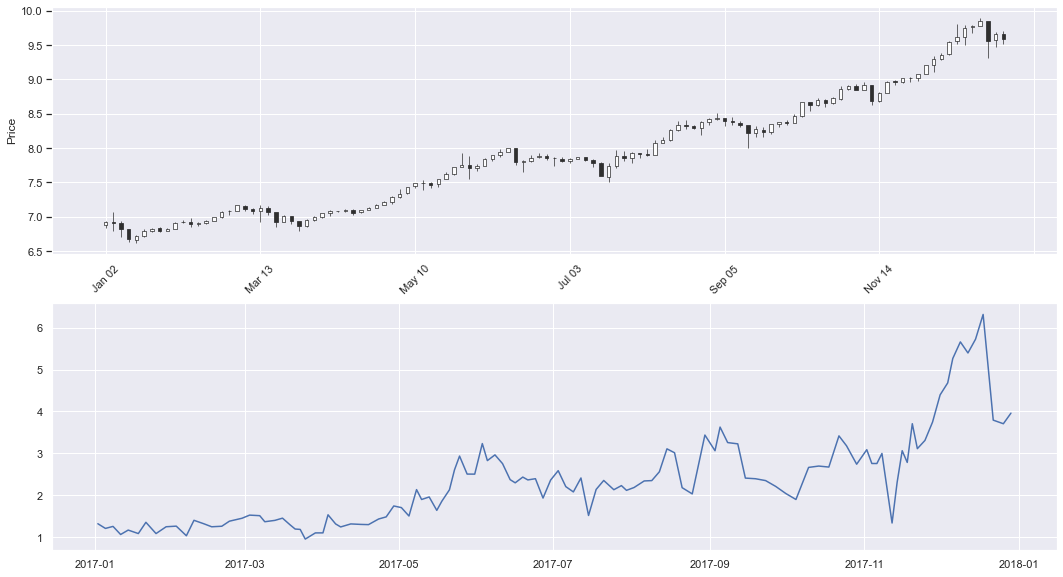

In [12]:
cols = ['Open','High','Low','Close']
f,a = plt.subplots(nrows = 2)
mpf.plot(np.log(newOhlc.loc['2017',cols]),type='candle',ax = a[0])
a[1].plot(newOhlc.loc['2017','puell_multiple'])

In [13]:
newOhlc['R'] = 100*(newOhlc.Close/newOhlc.Close.shift(1)-1)

print('above 4:',
      newOhlc.loc[newOhlc.puell_multiple.shift(1)>4,'R'].mean())
print('between 3 and 4:',
      newOhlc.loc[(newOhlc.puell_multiple.shift(1)<4) & (newOhlc.puell_multiple.shift(1)>3) ,'R'].mean())
print('between 0.5 and 3:',
      newOhlc.loc[(newOhlc.puell_multiple.shift(1)<3) & (newOhlc.puell_multiple.shift(1)>0.5) ,'R'].mean())
print('below 0.5:',
      newOhlc.loc[(newOhlc.puell_multiple.shift(1)<0.5),'R'].mean())

above 4: 7.438375415084582
between 3 and 4: 2.168922565753591
between 0.5 and 3: 1.3202779621484124
below 0.5: 0.40684045235664845


# Reserve risk

<AxesSubplot:>

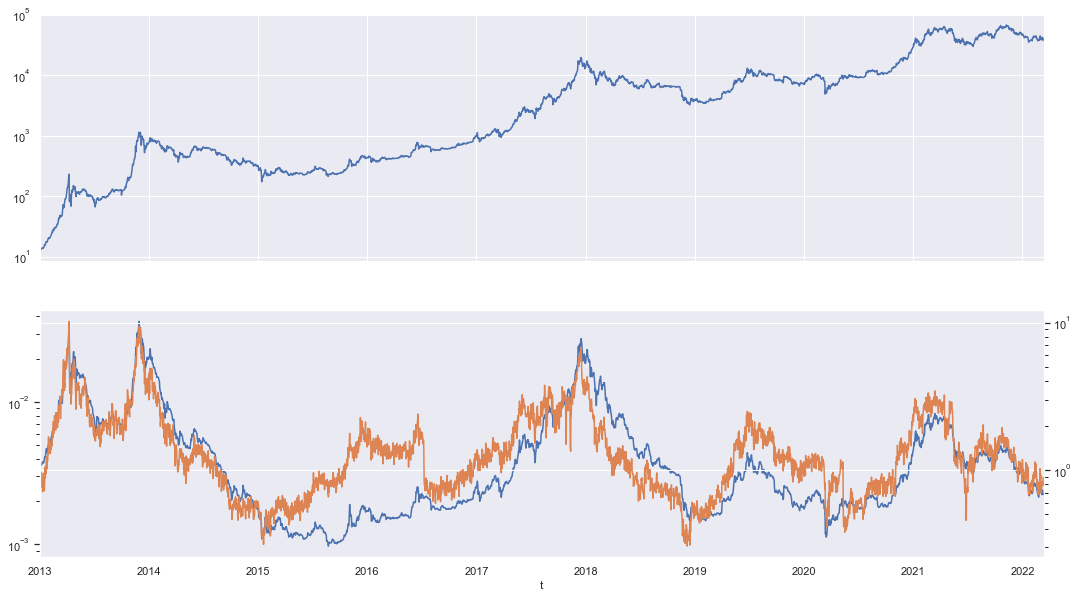

In [14]:
df = pd.concat([ohlc.Close,features[['reserve_risk','puell_multiple']]],axis = 1).dropna()


f,a = plt.subplots(nrows = 2, sharex = True)
df['Close'].plot(ax = a[0],logy = True)

df['reserve_risk'].plot(ax = a[1],logy=True)
df['puell_multiple'].plot(ax = a[1],logy=True,secondary_y=True)


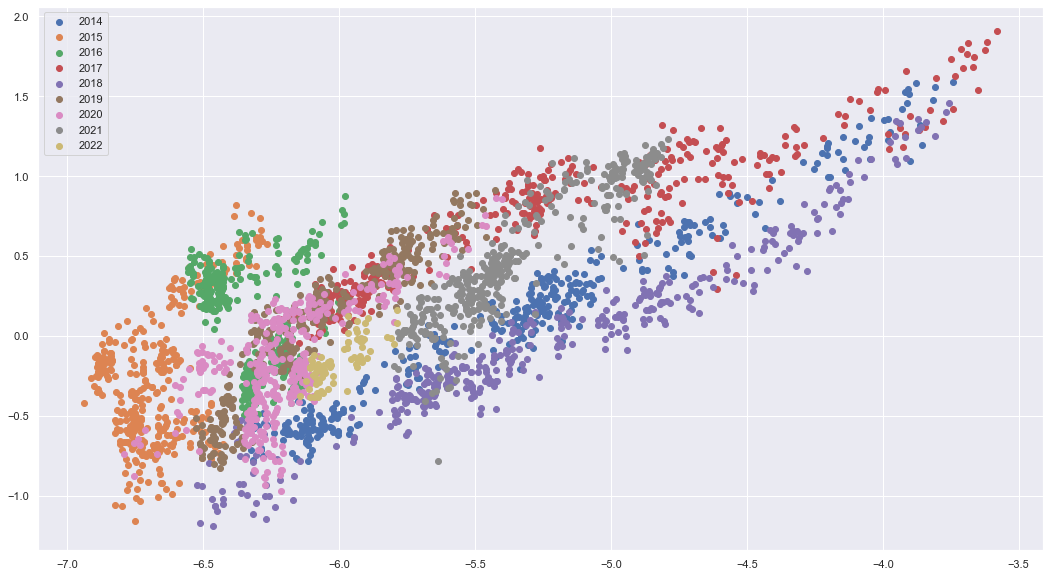

In [15]:
years = np.unique(df.index.year)

for y in years[1:]:
    plt.scatter(np.log(df.loc[str(y)].reserve_risk),
                np.log(df.loc[str(y)].puell_multiple),label = y)
    
plt.legend()

<AxesSubplot:xlabel='t'>

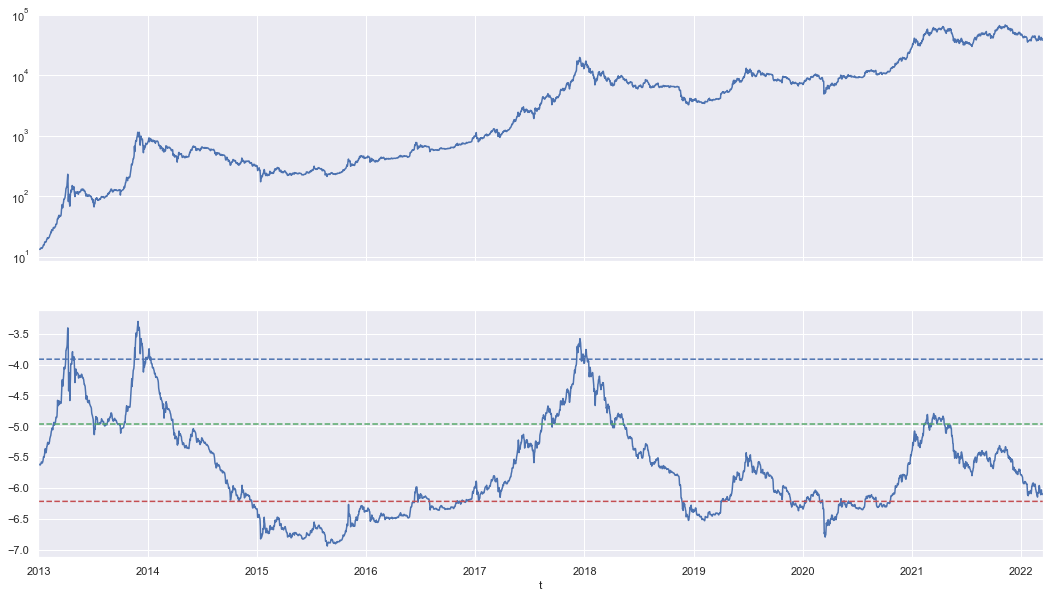

In [16]:
cycle_top = pd.Series(0.02,index = df.index)
local_top = pd.Series(0.007,index = df.index)
cycle_bottom = pd.Series(0.002,index = df.index)

f,a = plt.subplots(nrows = 2, sharex = True)
df['Close'].plot(ax = a[0],logy = True)

np.log(df['reserve_risk']).plot(ax = a[1])
np.log(cycle_top).plot(ax = a[1],style = 'b--')
np.log(local_top).plot(ax = a[1],style = 'g--')
np.log(cycle_bottom).plot(ax = a[1],style = 'r--')


In [17]:
df['R']=100*(df.Close/df.Close.shift(1)-1)

print('above 0.02:',
      df.loc[df.reserve_risk.shift(1)>0.02,'R'].mean())
print('between 0.02 and 0.007:',
      df.loc[(df.reserve_risk.shift(1)<0.02) & (df.reserve_risk.shift(1)>0.007) ,'R'].mean())
print('between 0.007 and 0.002:',
      df.loc[(df.reserve_risk.shift(1)<0.007) & (df.reserve_risk.shift(1)>0.002) ,'R'].mean())
print('below 0.002:',
      df.loc[(df.reserve_risk.shift(1)<0.002),'R'].mean())

above 0.02: -0.9143459834042467
between 0.02 and 0.007: 0.8843352026379161
between 0.007 and 0.002: 0.2539119350799709
below 0.002: 0.2663664696116907


In [18]:
OHLC = pd.concat([ohlc,features[['transfers_volume_sum','reserve_risk']]],axis=1).dropna().copy()
newOhlc,group = bar_create(OHLC,what = 'transfers_volume_sum',th = 3.5*1e6)
newOhlc = pd.concat([newOhlc,OHLC['reserve_risk']],axis=1).dropna()


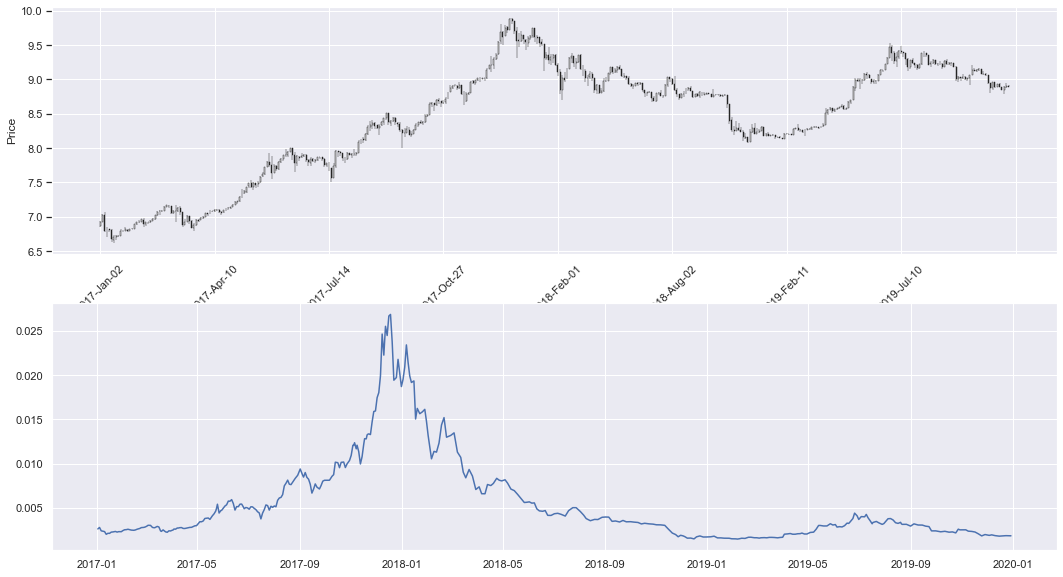

In [19]:
cols = ['Open','High','Low','Close']
f,a = plt.subplots(nrows = 2)
mpf.plot(np.log(newOhlc.loc['2017':'2019',cols]),type='candle',ax = a[0])
a[1].plot(newOhlc.loc['2017':'2019','reserve_risk'])

In [20]:
newOhlc['R']=100*(newOhlc.Close/newOhlc.Close.shift(1)-1)

print('above 0.02:',
      newOhlc.loc[newOhlc.reserve_risk.shift(1)>0.02,'R'].mean())
print('between 0.02 and 0.007:',
      newOhlc.loc[(newOhlc.reserve_risk.shift(1)<0.02) & (newOhlc.reserve_risk.shift(1)>0.007) ,'R'].mean())
print('between 0.007 and 0.002:',
      newOhlc.loc[(newOhlc.reserve_risk.shift(1)<0.007) & (newOhlc.reserve_risk.shift(1)>0.002) ,'R'].mean())
print('below 0.002:',
      newOhlc.loc[(newOhlc.reserve_risk.shift(1)<0.002),'R'].mean())

above 0.02: -1.0255915208734552
between 0.02 and 0.007: 2.536844541085139
between 0.007 and 0.002: 0.68288890356763
below 0.002: 0.7022479496026408


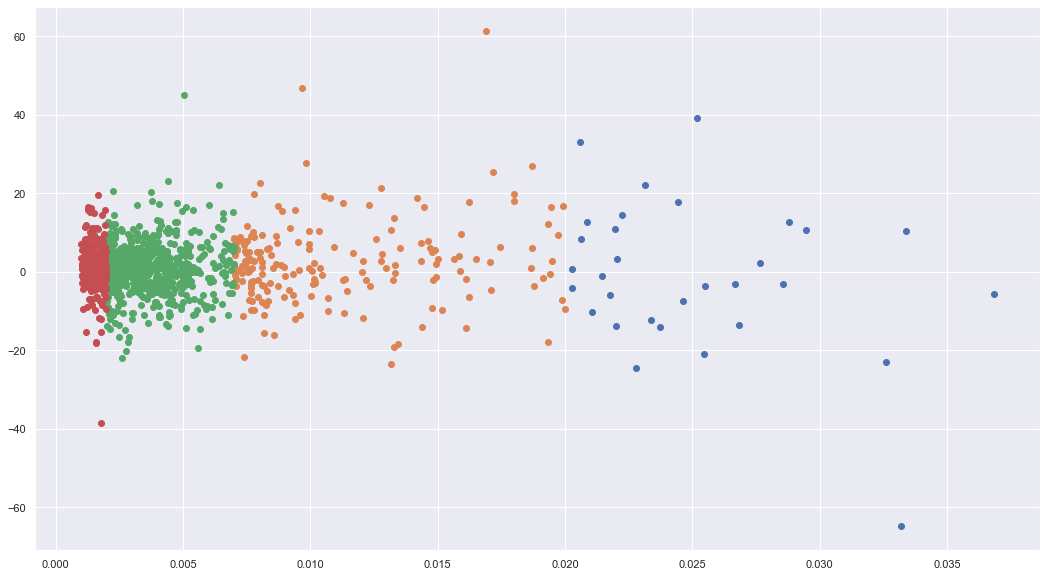

In [21]:
newOhlc['LRR'] = newOhlc.reserve_risk.shift(1)

plt.scatter(newOhlc.loc[newOhlc['LRR']>0.02,'LRR'],
            newOhlc.loc[newOhlc['LRR']>0.02,'R'])

plt.scatter(newOhlc.loc[(newOhlc['LRR']<0.02) & (newOhlc['LRR']>0.007),'LRR'],
            newOhlc.loc[(newOhlc['LRR']<0.02) & (newOhlc['LRR']>0.007),'R'])

plt.scatter(newOhlc.loc[(newOhlc['LRR']<0.007) & (newOhlc['LRR']>0.002),'LRR'],
            newOhlc.loc[(newOhlc['LRR']<0.007) & (newOhlc['LRR']>0.002),'R'])

plt.scatter(newOhlc.loc[(newOhlc['LRR']<0.002),'LRR'],
            newOhlc.loc[(newOhlc['LRR']<0.002),'R'])


# Adjusted SOPR

<AxesSubplot:xlabel='t'>

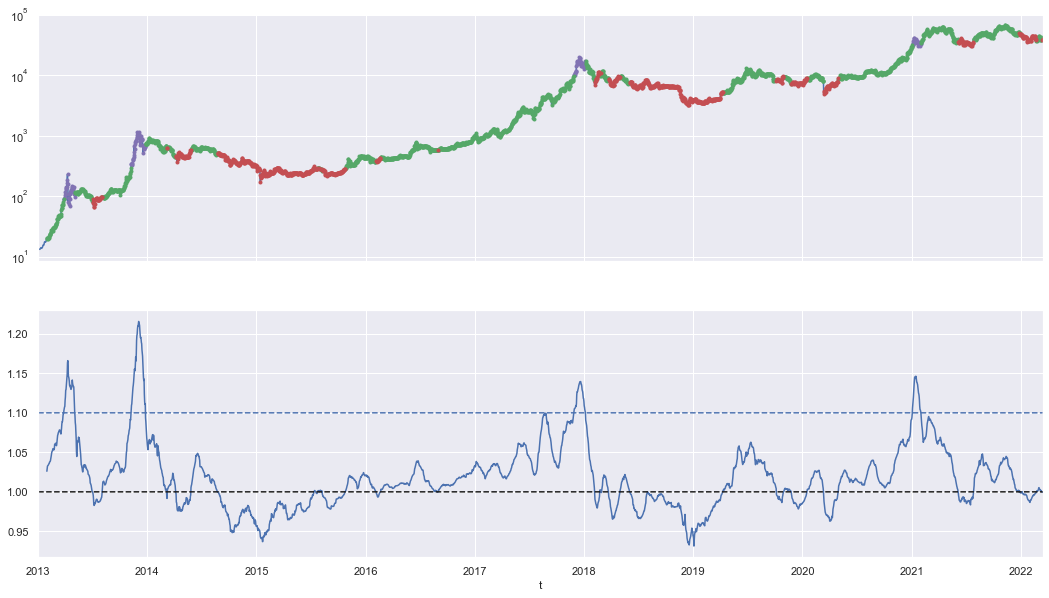

In [22]:
df = pd.concat([ohlc.Close,features[['reserve_risk','puell_multiple','sopr_adjusted']]],axis = 1).dropna()
df['sopr_adjusted_ma'] = df['sopr_adjusted'].rolling(30).mean()

cycle_top = pd.Series(1.1,index = df.index)
cycle_bottom = pd.Series(1.,index = df.index)


f,a = plt.subplots(nrows = 2, sharex = True)
df['Close'].plot(ax = a[0],logy = True)
df['Close'].loc[df.sopr_adjusted_ma>1.1].plot(ax = a[0],logy = True,style = 'm.')
df['Close'].loc[(df.sopr_adjusted_ma<1.1) & (df.sopr_adjusted_ma>1)].plot(ax = a[0],logy = True,style = 'g.')
df['Close'].loc[(df.sopr_adjusted_ma<1)].plot(ax = a[0],logy = True,style = 'r.')

df['sopr_adjusted_ma'].plot(ax = a[1])
cycle_top.plot(ax = a[1],style = 'b--')
cycle_bottom.plot(ax = a[1],style = 'k--')


In [23]:
df['R']=100*(df.Close/df.Close.shift(1)-1)

print('above 1.1:',
      df.loc[df.sopr_adjusted_ma.shift(1)>0.02,'R'].mean())
print('between 1.1 and 1.0:',
      df.loc[(df.sopr_adjusted_ma.shift(1)<1.1) & (df.sopr_adjusted_ma.shift(1)>1.) ,'R'].mean())
print('below 1:',
      df.loc[(df.sopr_adjusted_ma.shift(1)<1.),'R'].mean())

above 1.1: 0.3317845760548586
between 1.1 and 1.0: 0.3318465497462438
below 1: 0.14140829157115767


<AxesSubplot:xlabel='t'>

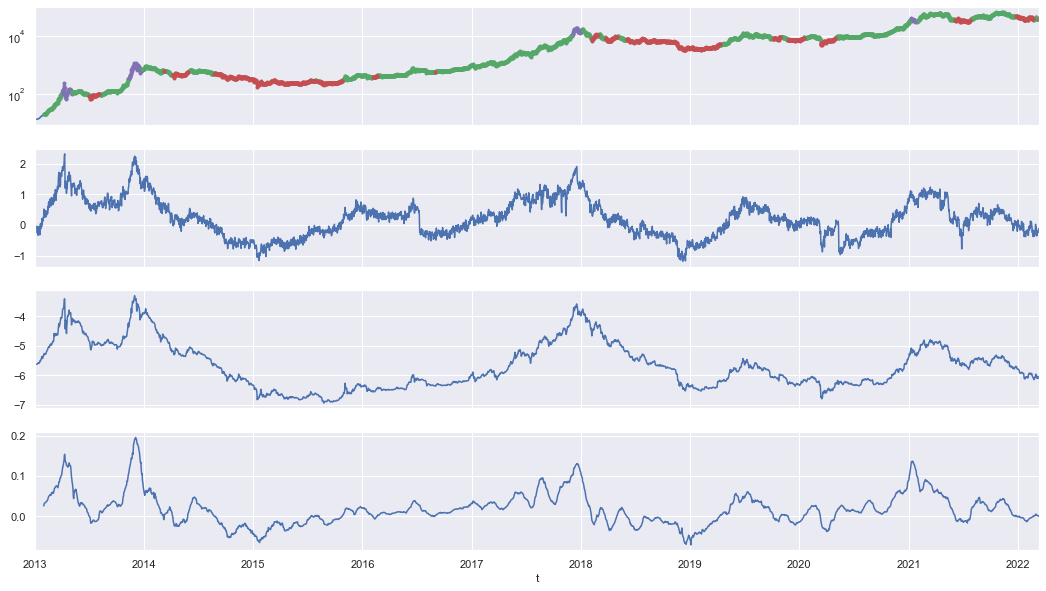

In [24]:
f,a = plt.subplots(nrows = 4, sharex = True)
df['Close'].plot(ax = a[0],logy = True)
df['Close'].loc[df.sopr_adjusted_ma>1.1].plot(ax = a[0],logy = True,style = 'm.')
df['Close'].loc[(df.sopr_adjusted_ma<1.1) & (df.sopr_adjusted_ma>1)].plot(ax = a[0],logy = True,style = 'g.')
df['Close'].loc[(df.sopr_adjusted_ma<1)].plot(ax = a[0],logy = True,style = 'r.')

np.log(df['puell_multiple']).plot(ax = a[1])
np.log(df['reserve_risk']).plot(ax = a[2])
np.log(df['sopr_adjusted_ma']).plot(ax = a[3])


In [25]:
df[['puell_multiple','reserve_risk','sopr_adjusted_ma']].corr()


,puell_multiple,reserve_risk,sopr_adjusted_ma
puell_multiple,1.000000,0.886689,0.840367
reserve_risk,0.886689,1.000000,0.700509
sopr_adjusted_ma,0.840367,0.700509,1.000000


# Entity 

<AxesSubplot:xlabel='t'>

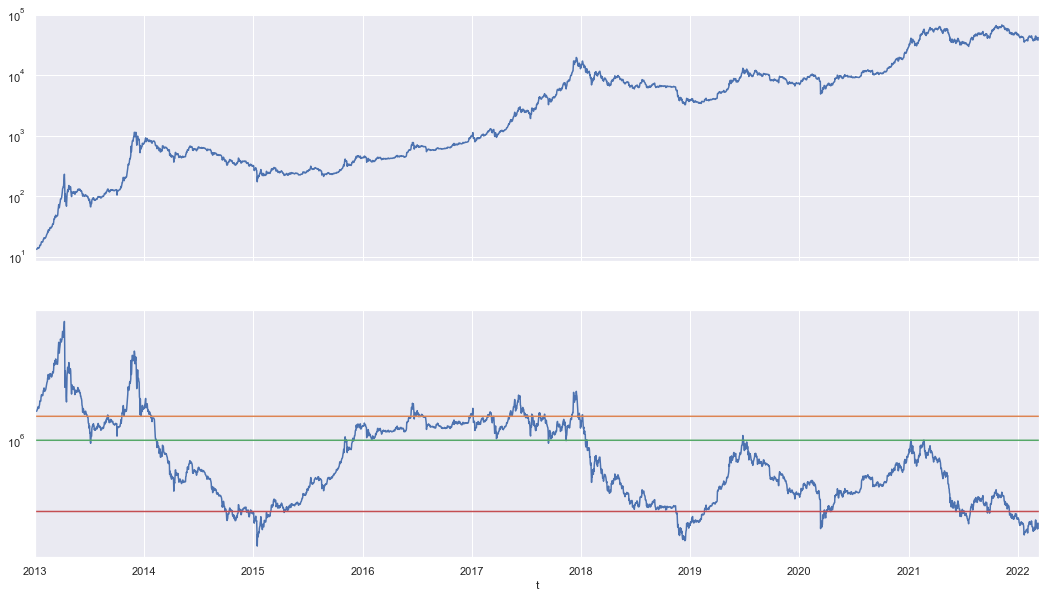

In [26]:
df = pd.concat([ohlc.Close,features[['reserve_risk','puell_multiple','sopr_adjusted','dormancy_flow']]],axis = 1).dropna()
df['sopr_adjusted_ma'] = df['sopr_adjusted'].rolling(30).mean()

cycle_top = pd.Series(1500000,index = df.index)
local_top = pd.Series(1000000,index = df.index)
cycle_bottom = pd.Series(300000,index = df.index)

f,a = plt.subplots(nrows = 2, sharex = True)
df['Close'].plot(ax = a[0],logy = True)
df['dormancy_flow'].plot(ax = a[1],logy = True)

cycle_top.plot(ax = a[1],logy = True)
local_top.plot(ax = a[1],logy = True)
cycle_bottom.plot(ax = a[1],logy = True)


In [27]:
df['R']=100*(df.Close/df.Close.shift(1)-1)

print('above 1,500,000:',
      df.loc[df.dormancy_flow.shift(1)>1500000,'R'].mean())
print('between 1,500,000 and 1,000,000:',
      df.loc[(df.dormancy_flow.shift(1)<1500000) & (df.dormancy_flow.shift(1)>1000000) ,'R'].mean())
print('between 1,000,000 and 300,000:',
      df.loc[(df.dormancy_flow.shift(1)<1000000) & (df.dormancy_flow.shift(1)>300000) ,'R'].mean())
print('below 300,000:',
      df.loc[(df.dormancy_flow.shift(1)<300000),'R'].mean())

above 1,500,000: 1.1265921088789002
between 1,500,000 and 1,000,000: 0.46313787984757243
between 1,000,000 and 300,000: 0.11959024389458026
below 300,000: 0.26606465985712435


# Cointegration

In [28]:
df = pd.concat([ohlc,features],axis = 1).dropna().loc['2014':]

In [ ]:
import statsmodels.tsa.stattools as ts 
from statsmodels.tsa.stattools import adfuller

pd.options.display.float_format = '{:,.4f}'.format

cols = features.columns

Coint = []
ADF = []

N = df.shape[0]
medpx = np.log(df[['High','Low']].mean(1)).rename('medpx')

for c in cols:
    data = pd.DataFrame()
    
    if (df[c]>=0).sum() == N:
        x = np.log(df[c])
    else:
        x = df[c]
        
    data = pd.concat([medpx,x],axis=1).dropna()

    period = data.index.strftime('%Y')
    cnt = data.groupby(period).apply(lambda x: ts.coint(x['medpx'],x[c],trend='ctt')[1]).rename(c)
    adf = data.groupby(period)[c].apply(lambda x: adfuller(x,regression='ctt')[1]).rename(c)
    Coint.append(cnt)
    ADF.append(adf)
    
Coint = pd.concat(Coint,axis=1)
ADF = pd.concat(ADF,axis=1)

print('Cointegration')
print('-------------')
display(Coint)
print('')
print('Unit root')
print('---------')
display(ADF)

In [ ]:
R = 100*np.log(df['Close']/df['Open']).rename('R')

Rdf = [R]

for c in cols:
    if c != 'marketcap_usd':
        if (df[c]>=0).sum() == N:
            x = np.log(df[c])
        else:
            x = df[c]

        pval = adfuller(x,regression='ctt')[1]

        if pval<0.1:
            Rdf.append(x)
        else:
            Rdf.append(x.diff())
        
Rdf = pd.concat(Rdf,axis=1).dropna()
sns.heatmap(Rdf.corr(),annot=True,cmap="YlGnBu")

ERROR! Session/line number was not unique in database. History logging moved to new session 932


# Create Targets

In [29]:
import talib as ta

px = np.log(ohlc.Close)
wpx = np.log(ta.WCLPRICE(ohlc.High, ohlc.Low, ohlc.Close))

upperband, middleband, lowerband = ta.BBANDS(px,
                                             timeperiod=12, 
                                             nbdevup=2, 
                                             nbdevdn=2, 
                                             matype=0)

# real = ta.HT_DCPERIOD(ohlc.Close)
# real = ta.ADXR(ohlc.High, ohlc.Low, ohlc.Close, timeperiod=14)
# real = ta.HT_TRENDLINE(np.log(ohlc.Close))
real = ta.CCI(np.log(ohlc.High), np.log(ohlc.Low), np.log(ohlc.Close), timeperiod=12)


ERROR! Session/line number was not unique in database. History logging moved to new session 933


<AxesSubplot:xlabel='t'>

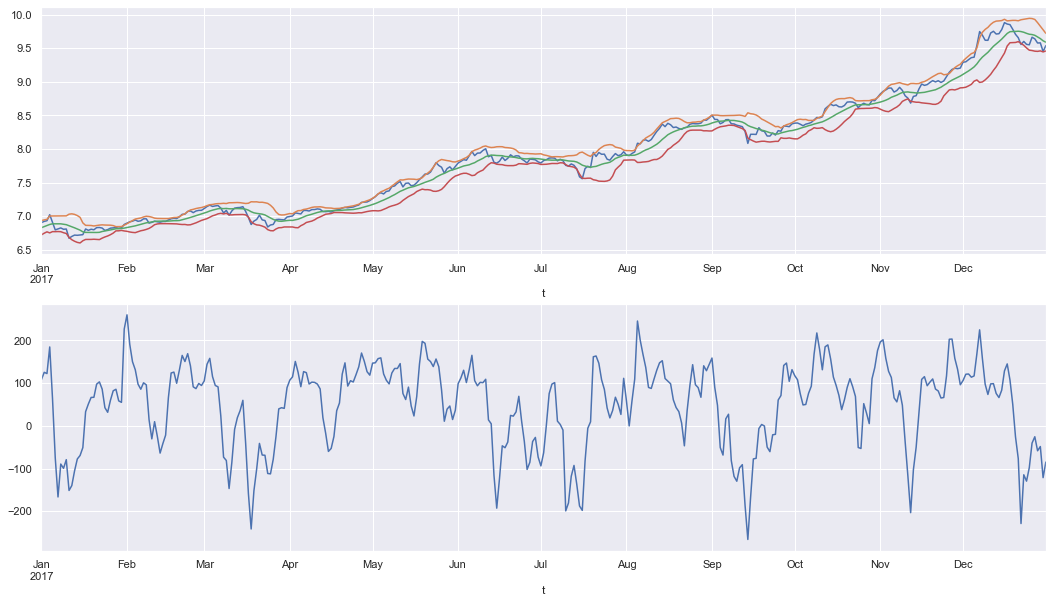

In [30]:
f,a = plt.subplots(nrows=2)
px.loc['2017'].plot(ax=a[0])
upperband.loc['2017'].plot(ax=a[0])
middleband.loc['2017'].plot(ax=a[0])
lowerband.loc['2017'].plot(ax=a[0])
real.loc['2017'].plot(ax=a[1])


In [231]:
target_df = pd.DataFrame(px)
L = 5

target_df['R'] = px.diff()
target_df['RV'] = np.sqrt((target_df['R']**2).rolling(L).sum())
target_df['FR'] = (px.shift(-L) - px)
target_df['FR2RV'] = target_df['FR']/target_df['RV']
target_df['Target'] = 0.
target_df.loc[target_df.FR2RV>=1.,'Target']=1.
target_df.loc[target_df.FR2RV<=-1.,'Target']=-1.

target_df = target_df.dropna()

In [232]:
# f,a = plt.subplots(nrows=2)
# target_df.loc['2017','Close'].plot(ax=a[0])
# target_df.loc[target_df.Target==1,'Close'].loc['2017'].plot(ax=a[0],style = 'go')
# target_df.loc[target_df.Target==-1,'Close'].loc['2017'].plot(ax=a[0],style = 'ro')
# target_df.loc[:,'RV'].loc['2017'].plot(ax=a[1])

In [233]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

def on_chain_classifier(data,train_period,cv_period,
                        freqency = '%Y-%m',options = {'max_depth':3}):
    
    train_data = data.loc[data.index.strftime(freqency).isin(train_period)]
    
    try:
        cv_data = data.loc[data.index.strftime(freqency).isin(cv_period)]
    except:
        cv_data = data.loc[data.index.strftime(freqency).isin([cv_period])]
        
    y_train,X_train = train_data['Target'],train_data.loc[:,train_data.columns != 'Target']
    y_cv,X_cv = cv_data['Target'],cv_data.loc[:,cv_data.columns != 'Target']
    
    clf = DecisionTreeClassifier(random_state=0,max_depth = options['max_depth'])
    clf.fit(X_train,y_train)
    yhat_cv = pd.Series(clf.predict(X_cv),index = y_cv.index,name = 'y_hat_cv')
    res = pd.concat([yhat_cv,y_cv],axis=1)
    return res

In [234]:

selected = ['marketcap_usd',
            'mvrv_z_score',
            'sopr_adjusted',
            'puell_multiple',
            'net_unrealized_profit_loss',
            'transfers_volume_sum',
            'transfers_volume_exchanges_net',
            'dormancy_flow',
            'reserve_risk',
            'cdd90_age_adjusted',
            'average_dormancy',
            'liveliness', 
            'realized_profits_to_value_ratio',
            'rhodl_ratio',
            'cvdd',
            'nvts', 
            'marketcap_thermocap_ratio',
            'difficulty_latest', 
            'non_zero_count']


feats = features[selected]# .rolling(1).mean()

data = pd.concat([target_df['Target'],feats],axis=1).dropna()

dates = np.unique(data.index.strftime('%Y-%m-%d'))
strided_dates = strided_app(dates,252,1)
M = strided_dates.shape[0]

results = [
    on_chain_classifier(data,
                        strided_dates[t,:-1],
                        strided_dates[t,-1],
                        freqency = '%Y-%m-%d',
                        options = {'max_depth':3})
    
    for t in tqdm(range(M))]

results = pd.concat(results,axis=0).sort_index()
print('accuracy:',accuracy_score(results.Target,results.y_hat_cv))

  0%|          | 0/3104 [00:00<?, ?it/s]

accuracy: 0.59375


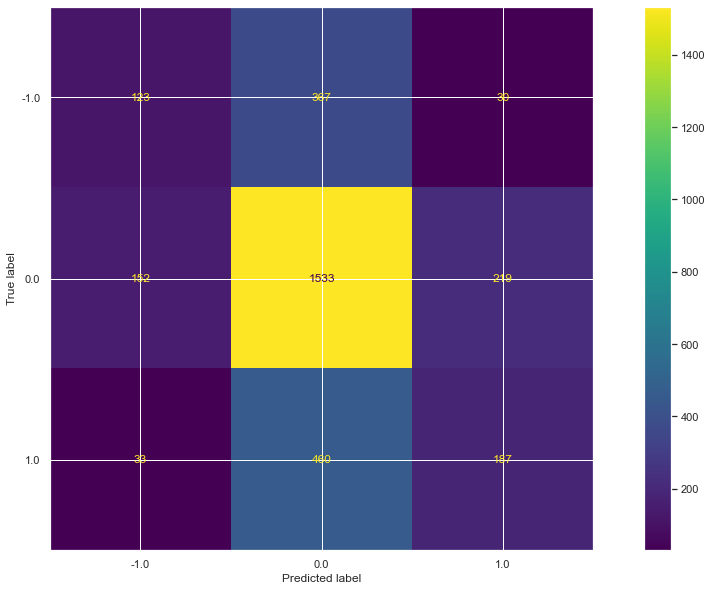

In [235]:
cm = confusion_matrix(results.Target, results.y_hat_cv)  
ConfusionMatrixDisplay.from_predictions(results.Target, results.y_hat_cv)
# ConfusionMatrixDisplay(cm)

In [236]:
cm = confusion_matrix(results.loc[:'2019'].Target, results.loc[:'2019'].y_hat_cv)  
print('% 1:',cm[-1,2]/cm[:,2].sum())
print('% -1:',cm[0,0]/cm[:,0].sum())
print('% 0:',cm[1,1]/cm[:,1].sum())

% 1: 0.4507936507936508
% -1: 0.3991228070175439
% 0: 0.6538024971623155


In [237]:
cm = confusion_matrix(results.loc['2020':].Target, results.loc['2020':].y_hat_cv)  
print('% 1:',cm[-1,2]/cm[:,2].sum())
print('% -1:',cm[0,0]/cm[:,0].sum())
print('% 0:',cm[1,1]/cm[:,1].sum())

% 1: 0.371900826446281
% -1: 0.4
% 0: 0.637123745819398


In [238]:
results_ = results.copy()

results_['R'] = np.log(ohlc.Close).diff().loc[results_.index]
results_['Price'] = ohlc.Close.loc[results_.index]

strategy_returns = [0]
pos_days = [0]
current_pos = [0]

for t in range(1,len(results_)):
    
    if pos_days[-1] == 0:
        if results_['y_hat_cv'].iloc[t-1] == 0.:
            strategy_returns.append(0.)
            pos_days.append(0.)
            current_pos.append(0)
            
        elif results_['y_hat_cv'].iloc[t-1] == 1.:
            strategy_returns.append(results_['R'].iloc[t])
            pos_days.append(pos_days[-1]+1)
            current_pos.append(1)
        elif results_['y_hat_cv'].iloc[t-1] == -1.:
            strategy_returns.append(-results_['R'].iloc[t])
            pos_days.append(pos_days[-1]+1)
            current_pos.append(-1)
            
    elif (pos_days[-1] > 0) & (pos_days[-1]<L+1):
        if current_pos[-1] == 1:
            strategy_returns.append(results_['R'].iloc[t])
            pos_days.append(pos_days[-1]+1)
            current_pos.append(1)
        elif current_pos[-1] == -1:
            strategy_returns.append(-results_['R'].iloc[t])
            pos_days.append(pos_days[-1]+1)
            current_pos.append(-1)
        
    elif pos_days[-1] == L+1.:
        strategy_returns.append(0)
        pos_days.append(0)
        current_pos.append(0)
        
results_['strategy_returns'] = strategy_returns


<AxesSubplot:xlabel='t'>

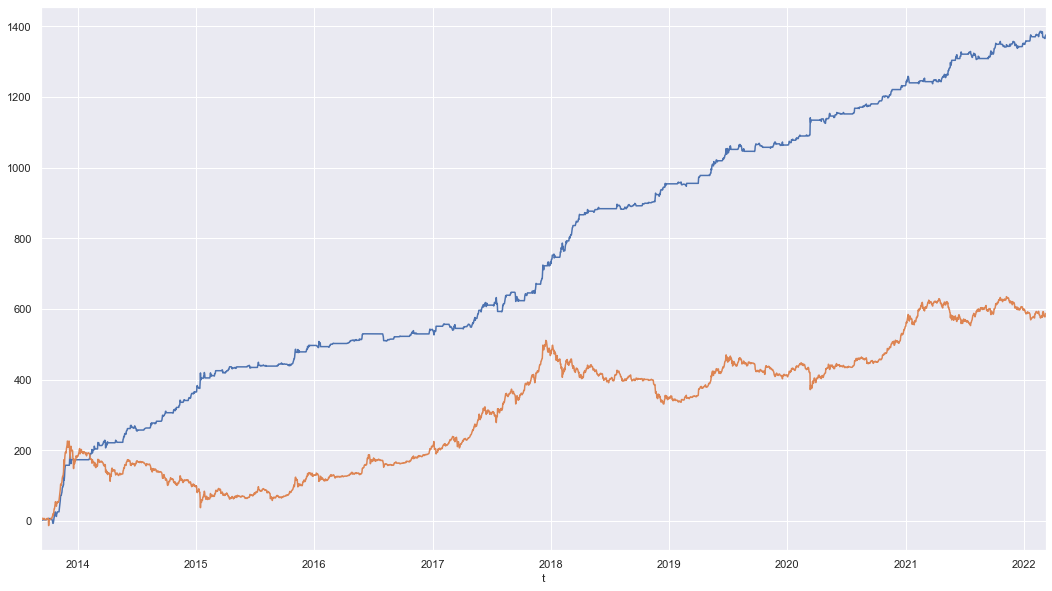

In [239]:
(100*results_.iloc[:,-1].cumsum()).plot()
(100*results_.R.cumsum()).plot()

In [240]:
R = np.log(ohlc.Close).diff().dropna()
strided_R = strided_app(R.values,L,1)
strided_dates = strided_app(R.index.values,L,1)

RetDates = pd.DataFrame(strided_R,index = strided_dates[:,0])
RetDates.iloc[:,0] = 0

In [241]:
long_positions = results_.loc[results_.y_hat_cv == 1,'y_hat_cv']
short_positions = results_.loc[results_.y_hat_cv == -1,'y_hat_cv']

positions = results_.loc[results_.y_hat_cv != 0,'y_hat_cv']
chain = pd.Series(0.,index = positions.index,dtype = float)
chain.iloc[0] = 1.

for t in range(1,len(positions)):
    tdelta = positions.index[t]-positions.index[t-1]
    if tdelta <= pd.Timedelta(str(L)+'D'):
        chain.iloc[t] = 1. + chain.iloc[t-1]
    else:
        chain.iloc[t] = 1.

In [242]:
posit = positions.loc[chain.loc[chain == 1].index]

In [243]:
LongR = RetDates.loc[posit.loc[posit == 1].index].sum(1)
ShortR = -RetDates.loc[posit.loc[posit == -1].index].sum(1)

In [244]:
res = pd.concat([LongR,ShortR],axis = 0).sort_index()



In [245]:
days = pd.Series(0.,index = results.index,name = 'days')
pos = pd.Series(0.,index = results.index,name = 'pos')
Ret = pd.Series(0.,index = results.index,name = 'Ret')

resu = pd.concat([results['y_hat_cv'],days,pos,Ret],axis = 1)

resu.loc[LongR.index,'pos'] = 1.
resu.loc[ShortR.index,'pos'] = -1.

nOHLC = ohlc.copy()
nOHLC['Volume'] = 100000
nOHLC['pos'] = 0.

In [246]:

for i in range(len(LongR.index)):
    t0 = LongR.index[i]
    t1 = LongR.index[i]+pd.Timedelta(str(L-1)+'D')
    
    resu.loc[t0:t1,'pos'] = 1
    resu.loc[t0:t1,'days'] = np.arange(L)+1
    resu.loc[t0:t1,'Ret'] = RetDates.loc[LongR.index[i]].values
    nOHLC.loc[t0:t1,'pos'] = 1


for i in range(len(ShortR.index)):
    t0 = ShortR.index[i]
    t1 = ShortR.index[i]+pd.Timedelta(str(L-1)+'D')
    
    resu.loc[t0:t1,'pos'] = -1
    resu.loc[t0:t1,'days'] = np.arange(L)+1
    resu.loc[t0:t1,'Ret'] = -RetDates.loc[ShortR.index[i]].values
    nOHLC.loc[t0:t1,'pos'] = -1


In [247]:
nOHLC['R'] = np.log(nOHLC.Close).diff().fillna(0)

nOHLC = nOHLC.loc[nOHLC.loc[nOHLC.pos!=0].index[0]:]

<AxesSubplot:xlabel='t'>

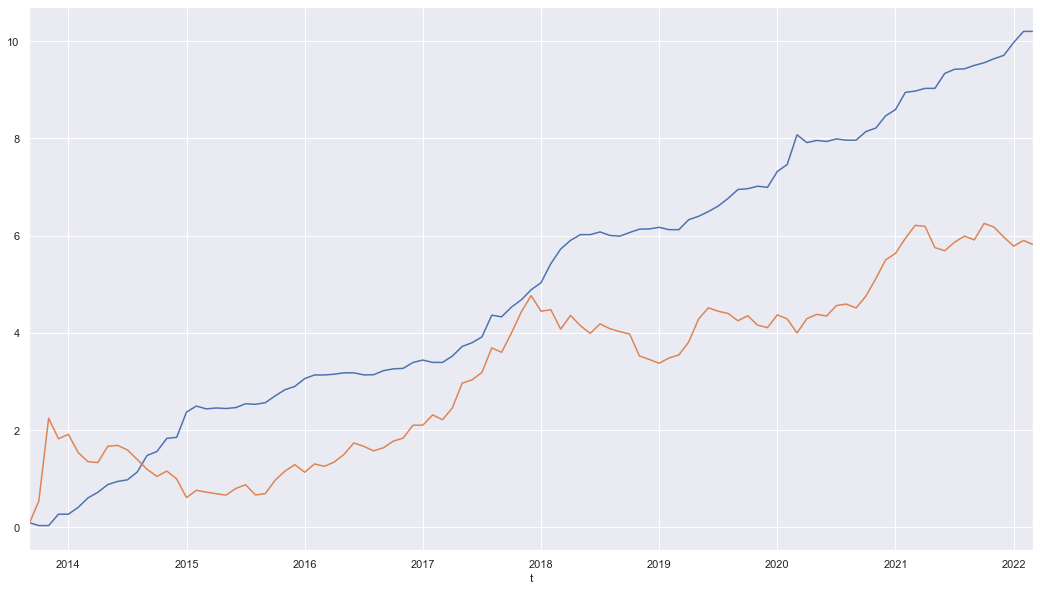

In [248]:
strategy = (nOHLC['R']*nOHLC['pos'])
bandh = nOHLC['R']

strategy.resample('1M').sum().cumsum().plot()
bandh.resample('1M').sum().cumsum().plot()

In [249]:
pd.concat([np.exp(strategy.resample('1Y').sum()).rename('strategy'),
           np.exp(bandh.resample('1Y').sum()).rename('Buy and Hold')],axis = 1)

,strategy,Buy and Hold
t,,
2013-12-31,1.3115,6.1852
2014-12-31,4.8596,0.4385
2015-12-31,2.8509,1.3403
2016-12-31,1.6350,2.2495
2017-12-31,4.4608,14.3598
2018-12-31,3.4940,0.2692
2019-12-31,2.3500,1.9238
2020-12-31,4.3539,4.0276
2021-12-31,3.4683,1.5982


In [250]:
res

2013-09-09    0.0509
2013-09-25    0.0297
2013-10-09   -0.0514
2013-12-05    0.1336
2014-02-03    0.1322
               ...  
2021-12-26    0.0739
2022-01-04    0.0955
2022-01-19    0.1407
2022-02-04    0.0606
2022-02-14    0.0622
Length: 146, dtype: float64

In [251]:
posit.groupby(posit.index.year).count().sum()


146